# ndi_syncgraph demo

This demo will showcase the use and operating principles of the class **ndi_syncgraph**. 

Note: some user intervention is required to open some of the demo data below. One must add one's own path to the 2014-05-09 experiment.


## Part 1: Background: what is ndi_syncgraph used for and what objects are used?

Different daqsystems usually have their own independent clocks and time offsets. Let's explore this by the way of some examples.

*Example 1: Simultaneous use of acquisition system A and B:*

Let's imagine that we have on our rig a data acquisition system by company A and another data acquisition system by company B. The scientist wants to record data using both of these systems. He/she turns on the acquisition system A, which begins logging data, and then, a few seconds later, turns on the acquisition system B, which also begins logging data. Usually, each epoch of data begins at a time t=0 on each acquisition system's local clock, and each sample is acquired at the sampling rate of that device. The problem is that the data acquired on acquisition system A and the data acquired on system B will almost necessarily not share the same time units.

Let's consider the time units of the samples on a daqsystem AA that manages data from acquisition system A. Almost always, the device will have a local label of the time of its samples, beginning at some t0 and continuing until t1 in increments of 1/sample_rate. In NDI, we call this `dev_local_time`. Some (rare) devices might also have an external clock input that expresses this time relative to some external clock. For example, one might imagine that there is some precise clock in the lab sending digital triggers at regular intervals to keep time, and perhaps the device has the option of labeling its time units according to this external clock. This external clock could be internal to the lab, and we call such a clock `exp_global_time`. Even better, this external clock could be synchronized to universal controlled time, and we call such a clock `utc`. 

In addition, devices sometimes know the time of their samples approximately relative to an external clock. For example, data acquisition system A might include a timestamp in its data file that indicates the time of the beginning of acquisition relative to the computer's internal clock. This time is not usually accurate at the level of tens of milliseconds, and generally can't be used to synchronize signals across systems at a resolution better than a couple seconds. We call such clocks `approx_exp_global_time` and `approx_utc`.

There is a data class, `ndi_clocktype`, that enumerates these possible clocks.

In [74]:
help ndi_clocktype/setclocktype

  SETCLOCKTYPE - Set the type of an NDI_CLOCKTYPE
 
  NDI_CLOCKTYPE_OBJ = SETCLOCKTYPE(NDI_CLOCKTYPE_OBJ, TYPE)
 
  Sets the TYPE property of an NDI_CLOCKTYPE object NDI_CLOCKTYPE_OBJ.
  Valid values for the TYPE string are as follows:
 
  TYPE string               | Description
  ------------------------------------------------------------------------------
  'utc'                     | Universal coordinated time (within 0.1ms)
  'approx_utc'              | Universal coordinated time (within 5 seconds)
  'exp_global_time'         | Experiment global time (within 0.1ms)
  'approx_exp_global_time'  | Experiment global time (within 5s)
  'dev_global_time'         | A device keeps its own global time (within 0.1ms) 
                            |   (that is, it knows its own clock across recording epochs)
  'approx_dev_global_time'  |  A device keeps its own global time (within 5 s) 
                            |   (that is, it knows its own clock across recording epochs)
  'dev_local_time

We can illustrate this by viewing an epochtable from an example experiment:

In [75]:
ndi_globals;
dirname = [ndiexampleexperpath filesep 'exp1_eg_saved'];
E = ndi_experiment_dir(dirname);
probes = E.getprobes();
 % compute the epochtable for this probe
et = probes{1}.epochtable();
 % let's examine the epochtable
et(1)


ans = 

  struct with fields:

         epoch_number: 1
             epoch_id: 'epoch_4126821d51dbc2cc_3fe1fc5cf5c69eff'
        epochprobemap: []
          epoch_clock: {[1x1 ndi_clocktype]}
                t0_t1: {[0 3.0000]}
    underlying_epochs: [1x1 struct]



We see that this epoch has a single epoch_clock type, but that it could potentially have a list of many different times. t0_t1 provides the time of the first and last samples in the units of the respective ndi_clocktype; for example, t0_t1{1} provides the time of the first and last samples in units of epoch_clock{1}. Let's look at this quantity for this epoch.

In [76]:
et(1).epoch_clock{1}


ans = 

  ndi_clocktype with properties:

    type: 'dev_local_time'



*Example 2: Simultaneous use of acquisition system A by different daqsystems:*

We can also imagine a situation where two daqsystems might manage data acquired by the same data acquisition device A. Let's imagine a daqsystem AA that manages data related to electrode recordings, and another daqsystem BB that combines information across multiple data acquisition systems, including A. As a concrete example, in my lab we typically acquire data on a single multifunction data acquisition system (by CED) related to both electrode recordings and digital triggers from our stimulus computer. We have an ndi_daqsystem_mfdaq object that manages the electrode data, but we have another object, a subclass of both type `ndi_daqsystem_mfdaq` and `ndi_daqsystem_stimulus`, that reads from the data acquisition system but also reads from status files generated by the stimulus computer. Therefore, one of the files that is used by both daqsystems is in common (the output file of the CED system), and this information can be used for synchronization.

So, suppose we want to know what time t in epoch n on daqsystem A translates to on daqsystem B? Which epoch m and which time t_prime corresponds? 

To calculate this, we need some way of finding how to map these two epochs onto each other. NDI specifies this problem at 2 levels. 

First, there is the level of the strategy that is used to synchronize the devices. These strategies are codified in `ndi_syncrule` objects. For example, if two daq systems acquire a common reference signal, then the channel numbers that acquire these reference channels can be passed to an (as yet undeveloped) ndi_syncrule class that receives this information.

The ndi_syncrule objects are used to create mappings between times and epochs across daq systems. These mappings are expressed in `ndi_timemapping` objects.

Let's look at these objects in more detail.

In [77]:
help ndi_syncrule

  NDI_SYNCRULE_OBJ - create a new NDI_SYNCRULE for managing synchronization
 
  NDI_SYNCRULE_OBJ = NDI_SYNCRULE(...)
   or
  NDI_SYNCRULE_OBJ = NDI_SYNCRULE(PARAMETERS)
 
  Creates a new NDI_SYNCRULE object with the given PARAMETERS (a structure).
  This is an abstract class, so PARAMETERS must be empty.

    Reference page in Doc Center
       doc ndi_syncrule




The only ndi_syncrule that is developed at this time is `ndi_syncrule_filematch`, which catches the condition that some of the files that make up the epochs on the 2 daqsystems match.

In [78]:
help ndi_syncrule_filematch

  NDI_SYNCRULE_FILEMATCH_OBJ - create a new NDI_SYNCRULE_FILEMATCH for managing synchronization
 
  NDI_SYNCRULE_FILEMATCH_OBJ = NDI_SYNCRULE_FILEMATCH()
       or
  NDI_SYNCRULE_FILEMATCH_OBJ = NDI_SYNCRULE_FILEMATCH(PARAMETERS)
 
  Creates a new NDI_SYNCRULE_FILEMATCH object with the given PARAMETERS (a structure, see below).
  If no inputs are provided, then the default PARAMETERS (see below) is used.
 
  PARAMETERS should be a structure with the following entries:
  Field (default)              | Description
  -------------------------------------------------------------------
  number_fullpath_matches (2)  | The number of full path matches of the underlying 
                               |  filenames that must match in order for the epochs to match.

    Reference page in Doc Center
       doc ndi_syncrule_filematch




In [79]:
methods('ndi_syncrule_filematch')


Methods for class ndi_syncrule_filematch:

apply                   ineligibleclocks        searchquery             
eligibleclocks          ineligibleepochsets     setparameters           
eligibleepochsets       isvalidparameters       
eq                      ndi_syncrule_filematch  
id                      newdocument             



In [80]:
help ndi_syncrule_filematch/apply

  APPLY - apply an NDI_SYNCRULE_FILEMATCH to obtain a cost and NDI_TIMEMAPPING between two NDI_EPOCHSET objects
 
  [COST, MAPPING] = APPLY(NDI_SYNCRULE_FILEMATCH_OBJ, EPOCHNODE_A, EPOCHNODE_B)
 
  Given an NDI_SYNCRULE_FILEMATCH object and two EPOCHNODES (see NDI_EPOCHSET/EPOCHNODES),
  this function attempts to identify whether a time synchronization can be made across these epochs. If so,
  a cost COST and an NDI_TIMEMAPPING object MAPPING is returned.
 
  Otherwise, COST and MAPPING are empty.



In [81]:
help ndi_timemapping

  NDI_TIMEMAPPING - class for managing mapping of time across epochs and devices
 
  Describes mapping from one time base to another. The base class, NDI_TIMEMAPPING, provides
  polynomial mapping, although usually only linear mapping is used.
  The property MAPPING is a vector of length N+1 that describes the coefficients of a
  polynomial such that:
 
  t_out = mapping(1)*t_in^N + mapping(2)*t_in^(N-1) + ... mapping(N)*t_in + mapping(N+1)
 
  Usually, one specifies a linear relationship only, with MAPPING = [scale shift] so that
 
  t_out = scale * t_in + shift

    Reference page in Doc Center
       doc ndi_timemapping




In [82]:
methods('ndi_timemapping')


Methods for class ndi_timemapping:

map              ndi_timemapping  



In [83]:
help ndi_timemapping/map

  MAP - perform a mapping from one time base to another
 
  T_OUT = MAP(NDI_TIMEMAPPING_OBJ, T_IN)
 
  Perform the mapping described by NDI_TIMEMAPPING_OBJ from one time base to another.
 
  In the base class NDI_TIMEMAPPING, the mapping is a polynomial.



## Part 2: Demo: using syncgraph

Now we will open an experiment that has 2 daqsystems and we'll show the ease that syncgraph provides to the user. 

*You will need the latest version of 2014-05-09 from the SquishyShare*.

In [84]:
prefix = ['/Users/vanhoosr/Desktop'] % edit this for your system


prefix =

    '/Users/vanhoosr/Desktop'



In [85]:
% Let's open up an experiment and examine the probes
E2 = ndi_experiment_dir([prefix filesep '2014-05-09'])
probes = E2.getprobes()
probes{1}, probes{2}, probes{3}


E2 = 

  ndi_experiment_dir with properties:

                path: '/Users/vanhoosr/Desktop/2014-05-09'
           reference: '2014-05-09'
    unique_reference: '412684472cf40177_3feddc959c9bd904'
           daqsystem: [1x1 ndi_dbleaf_branch]
           syncgraph: [1x1 ndi_syncgraph]
               cache: [1x1 ndi_cache]


probes =

  1x3 cell array

  Columns 1 through 2

    {1x1 ndi_probe_timeseries_mfdaq}    {1x1 ndi_probe_timeseries_mfdaq}

  Column 3

    {1x1 ndi_probe_timeseries_stimulator}


ans = 

  ndi_probe_timeseries_mfdaq with properties:

          experiment: [1x1 ndi_experiment_dir]
                name: 'intra'
                type: 'sharp-Vm'
           reference: 31
    underlying_thing: []
              direct: 1


ans = 

  ndi_probe_timeseries_mfdaq with properties:

          experiment: [1x1 ndi_experiment_dir]
                name: 'intra'
                type: 'sharp-Vm'
           reference: 32
    underlying_thing: []
              direct: 1


ans = 

  

In [86]:
% let's work with the first electrode channel, and the stimulus
sharpprobe = probes{1};
stimprobe = probes{3};

[data,t,timeref] = sharpprobe.readtimeseries(1,50,90); % read some data
 % this function returns the data and timestamps, as well as a timeref
 % that describes where the data came from
 timeref


timeref = 

  ndi_timereference with properties:

     referent: [1x1 ndi_probe_timeseries_mfdaq]
    clocktype: [1x1 ndi_clocktype]
        epoch: 1
         time: 0



In [87]:
% now we can use that timeref to read from the stimulator in the time base of the sharp electrode probe
[ds,ts]=stimprobe.readtimeseries(timeref, t(1), t(end));
% easy as pie


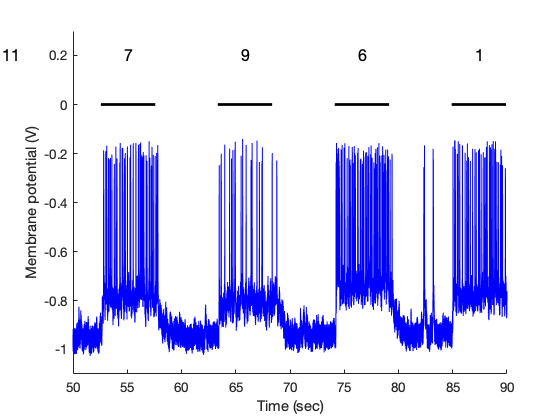

In [88]:
% now let's plot these together; we will use a helper function plot_stimulus_timeseries that plots
% stimulus numbers at their times of presentation
plot_stimulus_timeseries(0,ts.stimon,ts.stimoff,'stimid',ds.stimid,'textycoord',0.2);
hold on
plot(t,data,'b');
xlabel('Time (sec)');
ylabel('Membrane potential (V)');
axis([50 90 -1.1 0.3])
 % the black lines and the blue lines are from data from different daqsystems

## Part 3: Demo: how did syncgraph do it?

Now we will explore how syncgraph accomplished this feat. 

The probe epochs are derived from their daqsystem epochs, which are in turn derived from their filenavigator epochs. These epochs are all equivalent in acquisition times, but exist at different object levels. Let's follow this for the sharpprobe here.

In [89]:
et_sharp = sharpprobe.epochtable()
et_sharp_underlying = et_sharp(1).underlying_epochs


et_sharp = 

  struct with fields:

         epoch_number: 1
             epoch_id: 't00012'
        epochprobemap: []
          epoch_clock: {[1x1 ndi_clocktype]}
                t0_t1: {[0 501.2731]}
    underlying_epochs: [1x1 struct]


et_sharp_underlying = 

  struct with fields:

       underlying: [1x1 ndi_daqsystem_mfdaq]
         epoch_id: 't00012'
    epochprobemap: [1x1 ndi_epochprobemap_daqsystem_vhlab]
      epoch_clock: {[1x1 ndi_clocktype]}
            t0_t1: {[0 501.2731]}



We refer to the set of all underlying epochs along with each clocktype that each epoch has as the **epoch nodes**.

In [90]:
[enodes] = sharpprobe.epochnodes()


enodes = 

  struct with fields:

             epoch_id: 't00012'
        epochprobemap: []
          epoch_clock: [1x1 ndi_clocktype]
                t0_t1: [0 501.2731]
    underlying_epochs: [1x1 struct]
           objectname: 'probe: intra | 31'
          objectclass: 'ndi_probe_timeseries_mfdaq'



In [91]:
enodes(1).underlying_epochs


ans = 

  struct with fields:

       underlying: [1x1 ndi_daqsystem_mfdaq]
         epoch_id: 't00012'
    epochprobemap: [1x1 ndi_epochprobemap_daqsystem_vhlab]
      epoch_clock: {[1x1 ndi_clocktype]}
            t0_t1: {[0 501.2731]}



In [92]:
sg = E2.syncgraph


sg = 

  ndi_syncgraph with properties:

        experiment: [1x1 ndi_experiment_dir]
             rules: {[1x1 ndi_syncrule_filematch]}
    objectfilename: 'object_412684472cf40763_3fe907a6441c1b1b'
        identifier: '412684b939f245ca_3fdf6a5139fb9786'



We can examine the graph among epochnodes that was built by syncgraph:

In [93]:
%We can pull out syncgraph's graph and mapping functions from the experiment's cache:
[cache,key] = getcache(sg)
match = find(strcmp(key,{cache.table.key}))
GI = cache.table(match).data.graphinfo


cache = 

  ndi_cache with properties:

           maxMemory: 100000000
    replacement_rule: 'fifo'
               table: [1x12 struct]


key =

    'object_412684472cf40763_3fe907a6441c1b1b'


match =

    12


GI = 

  struct with fields:

      nodes: [1x12 struct]
          G: [12x12 double]
    mapping: {12x12 cell}
        diG: [1x1 digraph]



In [94]:
% The nodes correspond to every epoch in the experiment for every daqsystem, probe, etc, enumerated individually: 
for i=1:numel(GI.nodes),i,  GI.nodes(i), end


i =

     1


ans = 

  struct with fields:

             epoch_id: 't00012'
        epochprobemap: [1x1 ndi_epochprobemap_daqsystem_vhlab]
          epoch_clock: [1x1 ndi_clocktype]
                t0_t1: [0 501.2731]
    underlying_epochs: [1x1 struct]
           objectname: 'vhspike2'
          objectclass: 'ndi_daqsystem_mfdaq'


i =

     2


ans = 

  struct with fields:

             epoch_id: 't00013'
        epochprobemap: [1x1 ndi_epochprobemap_daqsystem_vhlab]
          epoch_clock: [1x1 ndi_clocktype]
                t0_t1: [0 709.4035]
    underlying_epochs: [1x1 struct]
           objectname: 'vhspike2'
          objectclass: 'ndi_daqsystem_mfdaq'


i =

     3


ans = 

  struct with fields:

             epoch_id: 't00014'
        epochprobemap: [1x1 ndi_epochprobemap_daqsystem_vhlab]
          epoch_clock: [1x1 ndi_clocktype]
                t0_t1: [0 814.0127]
    underlying_epochs: [1x1 struct]
           objectname: 'vhspike2'
          objectclass: 'ndi_daqsystem_

In [95]:
% The mapping stores the mapping among all of these nodes
 % everything maps to itself with a shift of 0 and a scale of 1 (y = x + 0)
GI.mapping{1,1}, % maps to itself
GI.mapping{1,2} % can't get there from here directly
GI.mapping{1,5} % we can get from node 1 to 5 directly because they are linked by a syncrule


ans = 

  ndi_timemapping with properties:

    mapping: [1 0]


ans =

     []


ans = 

  ndi_timemapping with properties:

    mapping: [1 0]



In [96]:
GI.nodes(3)


ans = 

  struct with fields:

             epoch_id: 't00014'
        epochprobemap: [1x1 ndi_epochprobemap_daqsystem_vhlab]
          epoch_clock: [1x1 ndi_clocktype]
                t0_t1: [0 814.0127]
    underlying_epochs: [1x1 struct]
           objectname: 'vhspike2'
          objectclass: 'ndi_daqsystem_mfdaq'



In [97]:
GI.diG


ans = 

  digraph with properties:

    Edges: [28x2 table]
    Nodes: [12x0 table]



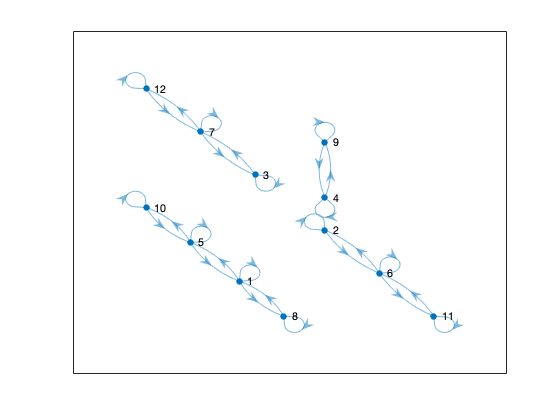

In [98]:
plot(GI.diG,'Layout','force')
 % every node maps to itself; there are 4 epochs here that are mapped across devices;
 % for example, node 1, 5, 8, and 10 are the probe and daqsystem epoch nodes for 
 % the data stored in directory t00012 (% note, 4 and 2 are not connected)